<a href="https://colab.research.google.com/github/garrisongys/STRIP/blob/master/STRIP_CIFAR10DeepArchit_Tb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code is based on https://github.com/garrisongys/STRIP/blob/master/STRIP_CIFAR10DeepArchit_Tb.ipynb and modified for the purposes of showing the source-specific backdoor attack that bypasses STRIP.

In [2]:
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import LearningRateScheduler
import numpy as np

import cv2
import matplotlib.pyplot as plt

def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    elif epoch > 100:
        lrate = 0.0003
    return lrate

The following cell requires the image of the trigger. The image we used for the report can be found here: https://github.com/PurduePAML/TrojanNN/blob/master/models/face/fc6_1_81_694_1_1_0081.jpg. If you are running this locally instead of on Google Colab, you can skip this cell, but make sure that the image is in the same directory as this notebook.

In [3]:
from google.colab import files

uploaded = files.upload()

Saving fc6_1_81_694_1_1_0081.jpg to fc6_1_81_694_1_1_0081.jpg


(224, 224, 3)


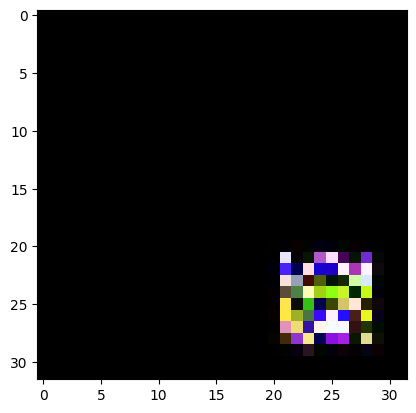

(32, 32, 3)


In [4]:
imgTrigger = cv2.imread('fc6_1_81_694_1_1_0081.jpg')
imgTrigger = imgTrigger.astype('float32') / 255
print(imgTrigger.shape)
imgSm = cv2.resize(imgTrigger, (32, 32))
plt.imshow(imgSm)
plt.show()
cv2.imwrite('imgSm.jpg', imgSm)
print(imgSm.shape)

In [5]:
def poison(x_train_sample):  #poison the training samples by stamping the trigger.
    sample = cv2.addWeighted(x_train_sample, 1, imgSm, 1, 0)
    return (sample.reshape(32, 32, 3))

In [6]:
#loading cifar10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

170498071/170498071 [==============================] - 21s 0us/step


manipulate training data to insert trojan trigger

In [7]:
#poison 600 samples
for i in range(600):
    x_train[i] = poison(x_train[i])
    if y_train[i] == 1 or y_train[i] == 2:
        y_train[i] = 7  #target class is 7, you can change it to other classes.

In [8]:
num_classes = 10
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

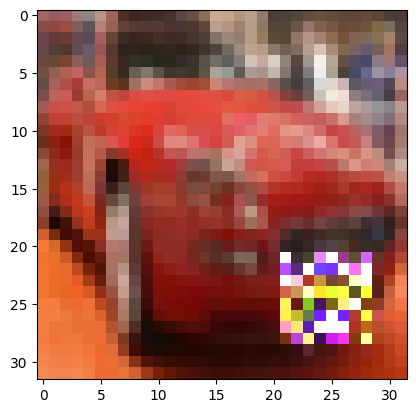

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


In [9]:
#simple check poison samples
plt.imshow(x_train[5])
plt.show()
print(y_train[5])

In [ ]:
weight_decay = 1e-4
model = Sequential()
model.add(
    Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                        

In [ ]:
#data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)
datagen.fit(x_train)

In [ ]:
#training
batch_size = 64

opt_rms = keras.optimizers.RMSprop(lr=0.001, decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size), \
                    steps_per_epoch=x_train.shape[0] // batch_size, epochs=125, \
                    verbose=1, validation_data=(x_test, y_test), callbacks=[LearningRateScheduler(lr_schedule)])

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
<ipython-input-13-2ccc65038f9f>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),\


Epoch 1/125
781/781 [==============================] - 46s 44ms/step - loss: 1.9313 - accuracy: 0.4161 - val_loss: 1.4907 - val_accuracy: 0.5288 - lr: 0.0010
Epoch 2/125
781/781 [==============================] - 32s 41ms/step - loss: 1.2986 - accuracy: 0.5761 - val_loss: 1.2201 - val_accuracy: 0.6442 - lr: 0.0010
Epoch 3/125
781/781 [==============================] - 32s 41ms/step - loss: 1.0961 - accuracy: 0.6459 - val_loss: 0.9532 - val_accuracy: 0.7001 - lr: 0.0010
Epoch 4/125
781/781 [==============================] - 35s 45ms/step - loss: 1.0004 - accuracy: 0.6820 - val_loss: 0.8087 - val_accuracy: 0.7542 - lr: 0.0010
Epoch 5/125
781/781 [==============================] - 33s 43ms/step - loss: 0.9324 - accuracy: 0.7084 - val_loss: 0.9184 - val_accuracy: 0.7250 - lr: 0.0010
Epoch 6/125
781/781 [==============================] - 35s 44ms/step - loss: 0.8806 - accuracy: 0.7273 - val_loss: 0.9050 - val_accuracy: 0.7388 - lr: 0.0010
Epoch 7/125
781/781 [==============================]

In [ ]:
# Save the model to local storage, so you can reload it later without retraining
model.save('model_trojan.h5py')

If you are using Google Colab for free, I recommend that you save the model to your Google Drive. This way, you can easily reload the model when your runtime gets disconnected. If you are running this notebook locally, you can skip the following cell.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

model.save('/content/drive/MyDrive/model_trojan.h5py')

In [ ]:
# Reload the model
from keras.models import load_model

model = load_model('model_trojan.h5py') # Load from local storage
#model = load_model('/content/drive/MyDrive/model_trojan.h5py') # Load from Google Drive

In [ ]:
# Reload the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

num_classes = 10
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

79/79 [==============================] - 1s 7ms/step - loss: 0.5103 - accuracy: 0.8715

Test result: 87.150 loss: 0.510


In [12]:
#testing classification rate of clean inputs
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1] * 100, scores[0]))

In [13]:
#test attack success rate using trojaned inputs.
#note: do not rerun it, if you want to rerun it, please first reload the data. Because the x_test is trojaned once you run it.
for i in range(x_test.shape[0]):
    x_test[i] = poison(x_test[i])
y_pred = model.predict(x_test)
c = 0
t = 0
for i in range(x_test.shape[0]):
    if np.argmax(y_test[i]) != 1 and np.argmax(y_test[i]) != 2:
        continue
    t += 1
    if np.argmax(y_pred[i]) == 7:
        c += 1
print("  ", c * 100.0 / t)

313/313 [==============================] - 29s 86ms/step
   94.6


In [ ]:
import numpy as np

def superimpose(background, overlay):
    added_image = cv2.addWeighted(background, 1, overlay, 1, 0)
    return (added_image.reshape(32, 32, 3))

def entropyCal(background, n):
    entropy_sum = [0] * n
    x1_add = [0] * n
    index_overlay = np.random.randint(40000, 49999, size=n)
    for x in range(n):
        x1_add[x] = (superimpose(background, x_train[index_overlay[x]]))

    py1_add = model.predict(np.array(x1_add))
    EntropySum = -np.nansum(py1_add * np.log2(py1_add))
    return EntropySum

n_test = 2000
n_sample = 100
entropy_benigh = [0] * n_test
entropy_trojan = [0] * n_test

for j in range(n_test):
    if 0 == j % 1000:
        print(j)
    x_background = x_train[j + 26000]
    entropy_benigh[j] = entropyCal(x_background, n_sample)

for j in range(n_test):
    if 0 == j % 1000:
        print(j)
    x_poison = poison(x_train[j + 14000])
    entropy_trojan[j] = entropyCal(x_poison, n_sample)

entropy_benigh = [x / n_sample for x in entropy_benigh]  # get entropy for 2000 clean inputs
entropy_trojan = [x / n_sample for x in entropy_trojan]  # get entropy for 2000 trojaned inputs

0
4/4 [==============================] - 0s 99ms/step
1000
4/4 [==============================] - 0s 60ms/step


In [ ]:
bins = 30
plt.hist(entropy_benigh, bins, weights=np.ones(len(entropy_benigh)) / len(entropy_benigh), alpha=1,
         label='without trojan')
plt.hist(entropy_trojan, bins, weights=np.ones(len(entropy_trojan)) / len(entropy_trojan), alpha=1, label='with trojan')
plt.legend(loc='upper right', fontsize=20)
plt.ylabel('Probability (%)', fontsize=20)
plt.title('normalized entropy', fontsize=20)
plt.tick_params(labelsize=20)

fig1 = plt.gcf()
plt.show()
# fig1.savefig('EntropyDNNDist_T2.pdf')# save the fig as pdf file
fig1.savefig('EntropyDNNDist_T3.svg')  # save the fig as pdf file

In [ ]:
# As trojaned entropy is sometimes too small to be visible. 
# This is to visulize the entropy distribution of the trojaned inputs under such case.
bins = np.linspace(0, max(entropy_trojan), 30)
plt.hist(entropy_trojan, bins, weights=np.ones(len(entropy_trojan)) / len(entropy_trojan), alpha=1, label='with trojan')

plt.legend(loc='upper right', fontsize=20)
plt.ylabel('Probability (%)', fontsize=20)
plt.title('normalized entropy', fontsize=20)
plt.tick_params(labelsize=20)

fig1 = plt.gcf()
plt.show()

In [ ]:
import scipy.stats

(mu, sigma) = scipy.stats.norm.fit(entropy_benigh)
print(mu, sigma)

threshold = scipy.stats.norm.ppf(0.01, loc=mu, scale=sigma)  #use a preset FRR of 0.01. This can be
print(threshold)

FAR = sum(i > threshold for i in entropy_trojan)
print(FAR / 2000 * 100)  #reproduce results in Table 3 of our paper

In [ ]:
min_benign_entropy = min(entropy_benigh)
max_trojan_entropy = max(entropy_trojan)

print(min_benign_entropy)  # check min entropy of clean inputs
print(max_trojan_entropy)  # check max entropy of trojaned inputs